In [1]:
import numpy as np
import fitsio
import healpy as hp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import random

In [2]:
exp = 11 # 11 Corresponds to a resolution of 2048
res = 2**exp

In [3]:
# This reads in the data for whichever condition we want to generate a plot for.
condFile = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/exptime_teff/y3a2_g_o.4096_t.32768_EXPTIME.SUM_EQU.fits.gz'
condMap = hp.fitsfunc.read_map(condFile, nest = True)
condMap[condMap==-1.6375e+30]=hp.UNSEEN
condSigExt=hp.ud_grade(condMap, res) # Stands for condition signal extended to whole map (not just valid pixels).

In [4]:
starFile = '/afs/hep.wisc.edu/bechtol-group/MegansThings/balrog_detection_catalog_sof_run2_stars_v1.4_avg_added_match_flags.fits'
# starFile = '/hdfs/bechtol/balrog/y3/balrog_detection_catalog_sof_y3-merged_v1.2.fits'
# This reads in all of the data. Most of these are just flags, the only pieces that get used much outside
# of filtering are true_ra and true_dec which get used to convert into healPixels.
starData = fitsio.read(starFile, columns = ['detected', 'true_ra', 'true_dec',
                                            'flags_foreground', 'flags_badregions', 'flags_footprint',
                                            'meas_FLAGS_GOLD_SOF_ONLY', 'match_flag_1.5_asec'])

In [5]:
# These are in degrees which is why lonlat is set to True in the next cell.
RA = starData['true_ra']
DEC = starData['true_dec']
# Everything from here on out is simply used in order to filter the data
DETECTED = starData['detected'] # This specifically is used for now to filter out any non detected injection.
FOREGROUND = starData['flags_foreground']
BADREGIONS = starData['flags_badregions']
FOOTPRINT = starData['flags_footprint']
GOLDSOF = starData['meas_FLAGS_GOLD_SOF_ONLY']
ARCSECONDS = starData['match_flag_1.5_asec']
# i_mag = starData['meas_cm_mag_deredden'][:,2] This gets used if we filter at all based on i magnitude.

# This is used to filter out any injections that either weren't detected or had flags raised.
cutIndices = np.where((FOREGROUND == 0) & 
                      (BADREGIONS < 2) & 
                      (FOOTPRINT == 1) & 
                      # (GOLDSOF < 2) &
                      (ARCSECONDS < 2))[0]

aveEff = 0.7521777482652668

DETECTED = DETECTED[cutIndices]
RA = RA[cutIndices]
DEC = DEC[cutIndices]

In [6]:
# This converts the RA and DEC values from above to healpixels so we can compare to the sky condition.
starPixels = hp.ang2pix(res, RA, DEC, lonlat = True, nest = True)

In [7]:
# Here I consider a valid pixel any pixel that has a non "bad value" for the condition and fracDet 
# and that has at least one of the filtered stars in it.
validPixels1 = np.full(12*(res**2), False, dtype = bool)
validPixels2 = np.full(12*(res**2), False, dtype = bool)
validPixels1[np.where(condSigExt >= 0)[0]] = True
validPixels2[starPixels] = True

validPixels = validPixels1 & validPixels2

In [8]:
# This gets the indices of the stars that are at valid pixels (this shouldn't filter out many at all).
starIndices = np.where(validPixels[starPixels])[0]

In [9]:
# This generates the condition values and fraction detected at the valid pixels.
condSig = condSigExt[validPixels]

# This tells me which pixels correspond to the values above.
condPix = np.where(validPixels)[0]

# This tells me the pixels for the stars, it will be the same as condPix but have repeats if multiple stars are detected
# on one pixel. By default these will not be sorted.
starPix = starPixels[starIndices]
DETVALIDPIX = DETECTED[starIndices]

# This sorts the pixels. This may seem like an unnecessarily difficult way to do it but it could be useful for future projects
# and it doesn't take much more space or time so I chose to leave it in.
sortInds = starPix.argsort()
starPix = starPix[sortInds[::1]]
DET = DETVALIDPIX[sortInds[::1]]

In [10]:
# These are indices that will be looping through the condPix and starPix arrays in parallel.
condInd = 0
starInd = 0

# This will be used to store the number of stars at each pixel.
detStar = np.zeros_like(condPix)
injStar = np.zeros_like(condPix)

while starInd < len(starPix):
    if condPix[condInd] == starPix[starInd]: # If the pixels match up in the arrays.
        detStar[condInd] += DET[starInd]
        injStar[condInd] += 1                # Add one to the corresponding spot in the balStar array.
        starInd += 1                         # Add one to the starInd to see if the next index in starPix is also the same.
        # Since the last index of condPix and starPix are the same, starInd will increase the last time through the loop,
        # making this the index that we must restrict in the while loop.
    else:
        condInd += 1 # If the pixels are no longer the same, increase the index you check in the condPix array.

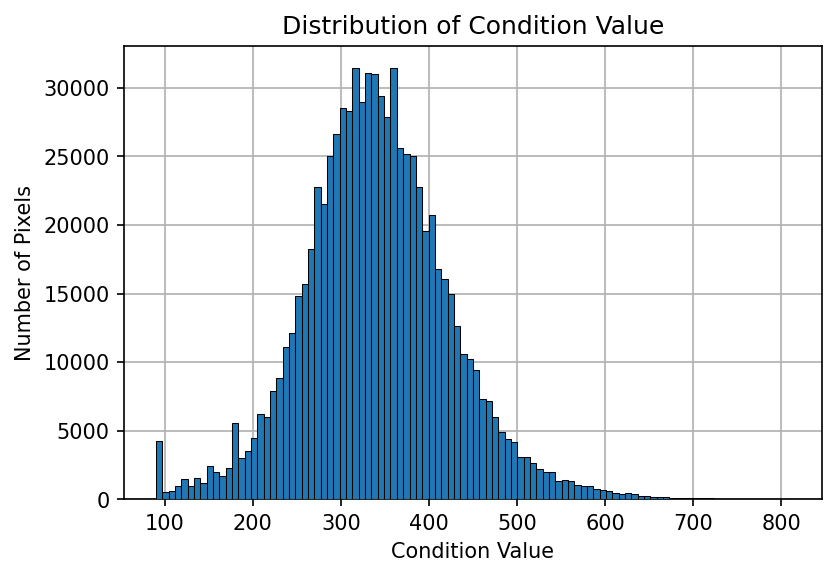

In [11]:
# This generates a plot of the distribution of the condition, which is useful for seeing what bin size to use.
plt.figure(dpi = 150)
plt.grid(zorder = 0)
plt.hist(condSig, bins = 100, edgecolor='black', linewidth=.5, zorder = 3)
plt.xlabel('Condition Value')
plt.ylabel('Number of Pixels')
plt.title('Distribution of Condition Value')
#plt.yscale('log')
plt.show()

In [12]:
# These set the lower and upper limits on the bins as well as the number of bins.
condMin = 100
condMax = 600
numBins = 25

In [13]:
# This generates the x values to be used in the final plot as the middle value of each bin.
xValues = np.linspace(condMin, condMax, numBins, endpoint = False) + (condMax - condMin) / (2 * numBins)

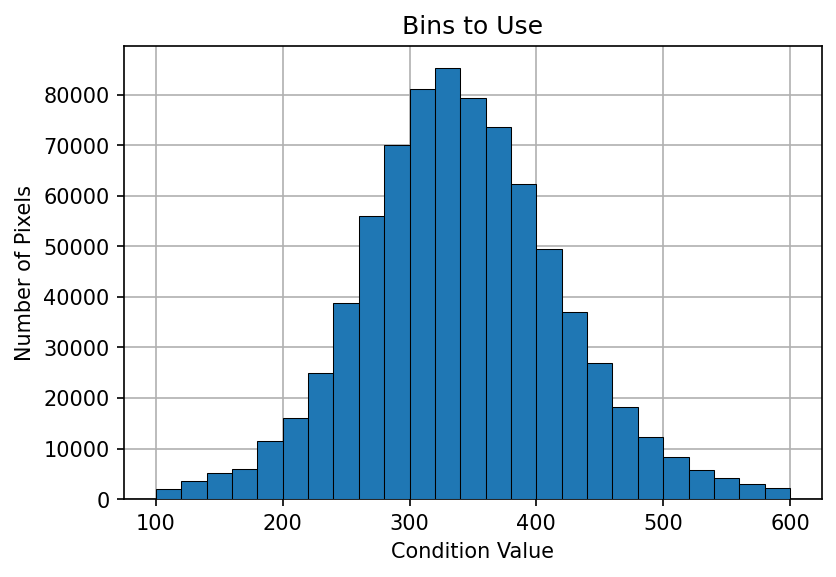

In [14]:
# This shows what the bins will actually look like, which can be useful in seeing if any of the bins are too small.
plt.figure(dpi = 150)
plt.grid(zorder = 0)
plt.hist(condSig, bins = np.linspace(condMin, condMax, numBins + 1), edgecolor='black', linewidth=.5, zorder = 3)
# plt.yscale('log')
plt.title('Bins to Use')
plt.xlabel('Condition Value')
plt.ylabel('Number of Pixels')
plt.show()

In [15]:
def binIndicesByCondition(cond, condMin, condMax, numBins): # This bins together the indices.
    binBounds = np.linspace(condMin, condMax, (numBins + 1), endpoint = True)
    indByBin = []
    for i in range(len(binBounds) - 1):
        validIndices = np.array(np.where((cond >= binBounds[i]) & (cond <= binBounds[i + 1]))[0])
        # I used both >= and <= even though this could result in repeats since what we're after is the "detection efficiency"
        # in a certain range of conditions and I didn't think repeats would really matter. Easy switch if desired though.
        indByBin.append(validIndices)
    return np.array(indByBin, dtype = object)

In [16]:
# This generates the indices for each bin.
binInd = binIndicesByCondition(condSig, condMin, condMax, numBins)

In [17]:
percentBins = []

for i in range(len(binInd)):
    totalDet = np.sum(detStar[binInd[i]]) # Total number of detections within the bin.
    totalInj = np.sum(injStar[binInd[i]])
    percentBins.append(totalDet / totalInj) # Total effective area within the bin.

relPerBins = np.array(percentBins) / aveEff # This normalizes the data, relative percent bins.
corrWeights = 1/relPerBins

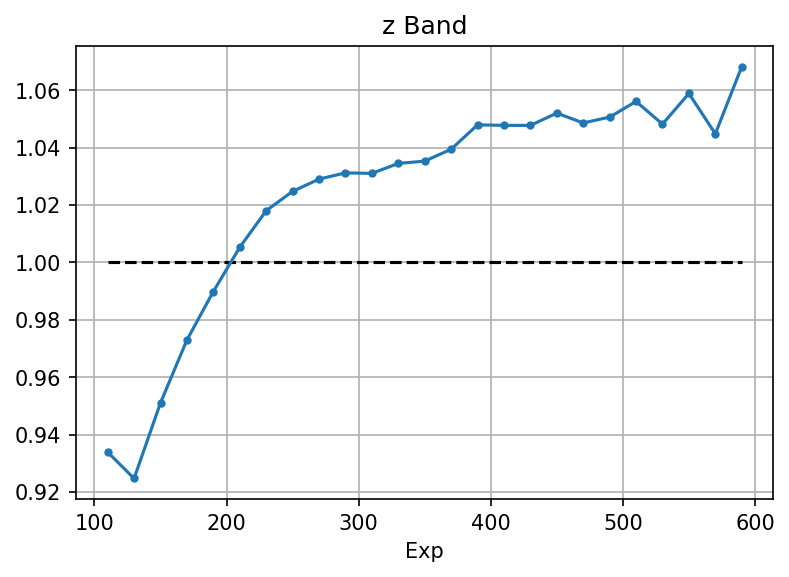

In [18]:
# This is the final plot.
plt.figure(dpi = 150)
plt.plot(xValues, 1/corrWeights, marker = '.', zorder = 3)
plt.plot(xValues, np.ones_like(xValues), color = 'k', linestyle = '--')
# plt.ylim([0.6, 1.3])
plt.title('z Band')
plt.ylabel('')
plt.xlabel('Exp')
plt.grid()
plt.show()

### Looking for Correlations

In [19]:
# # This reads in the data for whichever condition we want to generate a plot for.
# condFile2 = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/airmass/y3a2_g_o.4096_t.32768_AIRMASS.MAX_EQU.fits.gz'
# condMap2 = hp.fitsfunc.read_map(condFile2, nest = True)
# condMap2[condMap2==-1.6375e+30]=hp.UNSEEN
# condSigExt2=hp.ud_grade(condMap2,res) # Stands for condition signal extended to whole map (not just valid pixels).

In [20]:
# restInd = np.where((condSigExt >= 0) & (condSigExt2 >= 0))[0]

# comp1 = condSigExt[restInd]
# comp2 = condSigExt2[restInd]

In [21]:
# x = np.linspace(100, 600, 101)
# plt.figure(dpi = 150)
# plt.hist2d(comp1, comp2, bins = [np.linspace(1, 1.4, 101), np.linspace(1, 1.4, 101)], norm = LogNorm())
# plt.xlabel('Airmass')
# plt.ylabel('Airmass Max')
# plt.title('Correlation in Properties')
# plt.colorbar()
# #plt.plot(x, (2.2/np.sqrt(x/600)), color = 'r')
# plt.show()

In [22]:
# randComp1 = np.copy(comp1); random.shuffle(randComp1)

In [23]:
# plt.figure(dpi = 150)
# plt.hist2d(randComp1, comp2, bins = [np.linspace(1, 1.4, 101), np.linspace(1, 1.4, 101)], norm = LogNorm())
# plt.xlabel('Random Airmass')
# plt.ylabel('Airmass Max')
# plt.title('Correlation in Properties Randomly Rearranged')
# plt.colorbar()
# plt.show()

In [24]:
# print(np.sum(detStar)/np.sum(validPixels))

In [25]:
aveEff

0.7282926019070762

In [27]:
print(list(relPerBins))

[0.9339039662841981, 0.9247050604754933, 0.9510637380205208, 0.9729662151583613, 0.9898609444026589, 1.0052650600439528, 1.0180177699189266, 1.0247537507864293, 1.029028703956287, 1.0311983551190433, 1.0310295150613171, 1.034483874706746, 1.0353031120344958, 1.0394324050978871, 1.0479333328224807, 1.0477570890308587, 1.0477341864971434, 1.0520313695097159, 1.0486002203038576, 1.0506399299492553, 1.056092888407915, 1.0481727324475658, 1.0588834822109978, 1.044804421454789, 1.068206737416987]
